The MIT License (MIT)

Copyright (c) 2013 Vinnie Monaco

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.misc import imread
from skimage.feature import canny
from scipy.ndimage.filters import sobel

# Good for the b/w test images used
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50
    
def gradient_orientation(image):
    '''
    Calculate the gradient orientation for edge point in the image
    '''
    dx = sobel(image, axis=0, mode='constant')
    dy = sobel(image, axis=1, mode='constant')
    gradient = np.arctan2(dy,dx) * 180 / np.pi
    
    return gradient
    
def build_r_table(image, origin):
    '''
    Build the R-table from the given shape image and a reference point
    '''
    edges = canny(image, low_threshold=MIN_CANNY_THRESHOLD, 
                  high_threshold=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)
    
    r_table = defaultdict(list)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            r_table[gradient[i,j]].append((origin[0]-i, origin[1]-j))

    return r_table

def accumulate_gradients(r_table, grayImage):
    '''
    Perform a General Hough Transform with the given image and R-table
    '''
    edges = canny(grayImage, low_threshold=MIN_CANNY_THRESHOLD, 
                  high_threshold=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)
    
    accumulator = np.zeros(grayImage.shape)
    for (i,j),value in np.ndenumerate(edges):
        if value:
            for r in r_table[gradient[i,j]]:
                accum_i, accum_j = i+r[0], j+r[1]
                if accum_i < accumulator.shape[0] and accum_j < accumulator.shape[1]:
                    accumulator[accum_i, accum_j] += 1
                    
    return accumulator

def general_hough_closure(reference_image):
    '''
    Generator function to create a closure with the reference image and origin
    at the center of the reference image
    
    Returns a function f, which takes a query image and returns the accumulator
    '''
    referencePoint = (reference_image.shape[0]/2, reference_image.shape[1]/2)
    r_table = build_r_table(reference_image, referencePoint)
    
    def f(query_image):
        return accumulate_gradients(r_table, query_image)
        
    return f

def n_max(a, n):
    '''
    Return the N max elements and indices in a
    '''
    indices = a.ravel().argsort()[-n:]
    indices = (np.unravel_index(i, a.shape) for i in indices)
    return [(a[i], i) for i in indices]

def test_general_hough(gh, reference_image, query):
    '''
    Uses a GH closure to detect shapes in an image and create nice output
    '''
    query_image = imread(query, flatten=True)
    accumulator = gh(query_image)

    plt.clf()
    plt.gray()
    
    fig = plt.figure()
    fig.add_subplot(2,2,1)
    plt.title('Reference image')
    plt.imshow(reference_image)
    
    fig.add_subplot(2,2,2)
    plt.title('Query image')
    plt.imshow(query_image)
    
    fig.add_subplot(2,2,3)
    plt.title('Accumulator')
    plt.imshow(accumulator)
    
    fig.add_subplot(2,2,4)
    plt.title('Detection')
    plt.imshow(query_image)
    
    # top 5 results in red
    m = n_max(accumulator, 5)
    y_points = [pt[1][0] for pt in m]
    x_points = [pt[1][1] for pt in m] 
    plt.scatter(x_points, y_points, marker='o', color='r')

    # top result in yellow
    i,j = np.unravel_index(accumulator.argmax(), accumulator.shape)
    plt.scatter([j], [i], marker='x', color='y')
    
    d,f = os.path.split(query)[0], os.path.splitext(os.path.split(query)[1])[0]
    plt.show()
    
    return

def test():
    reference_image = imread("../general-hough/images/s.png", flatten=True)
    detect_s = general_hough_closure(reference_image)
    test_general_hough(detect_s, reference_image, "../general-hough/images/s_test.png")
    
    reference_image = imread("../general-hough/images/diamond.png", flatten=True)
    detect_s = general_hough_closure(reference_image)
    test_general_hough(detect_s, reference_image, "../general-hough/images/diamond_test1.png")
    test_general_hough(detect_s, reference_image, "../general-hough/images/diamond_test2.png")
    test_general_hough(detect_s, reference_image, "../general-hough/images/diamond_test3.png")
    test_general_hough(detect_s, reference_image, "../general-hough/images/diamond_test4.png")
    test_general_hough(detect_s, reference_image, "../general-hough/images/diamond_test5.png")
    test_general_hough(detect_s, reference_image, "../general-hough/images/diamond_test6.png")

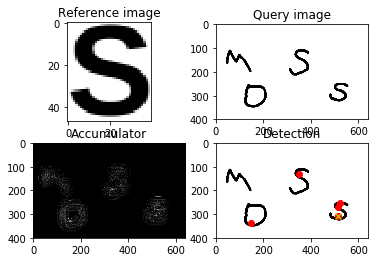

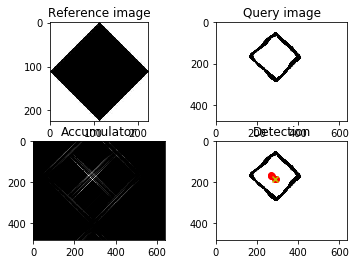

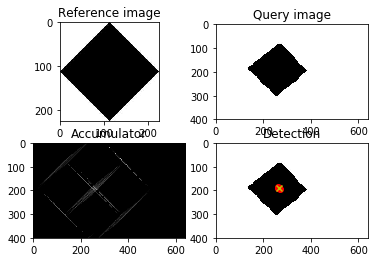

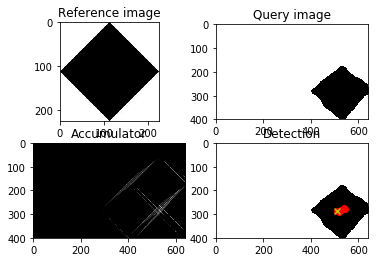

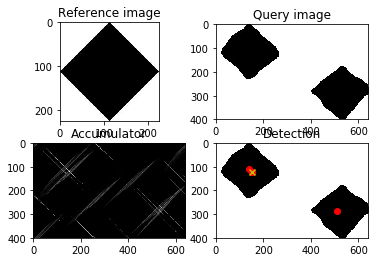

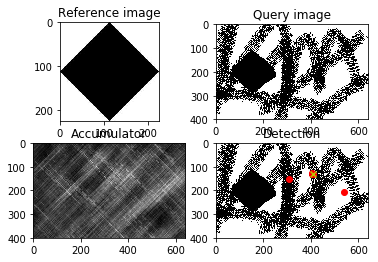

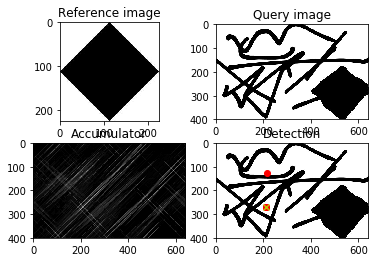

In [15]:
test()

# Now trying on pigs

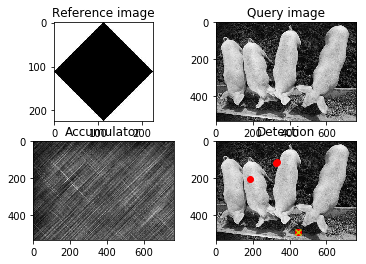

In [18]:
reference_image = imread("../general-hough/images/diamond.png", flatten=True)
detect_s = general_hough_closure(reference_image)
test_general_hough(detect_s, reference_image, "4_piglets.png")

In [19]:
reference_image

array([[ 255.,  255.,  255., ...,  255.,  255.,  255.],
       [ 255.,  255.,  255., ...,  255.,  255.,  255.],
       [ 255.,  255.,  255., ...,  255.,  255.,  255.],
       ..., 
       [ 255.,  255.,  255., ...,  255.,  255.,  255.],
       [ 255.,  255.,  255., ...,  255.,  255.,  255.],
       [ 255.,  255.,  255., ...,  255.,  255.,  255.]], dtype=float32)